# SVM Linear

## Importações

In [105]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

## Leitura de Dados

In [106]:
treinamento = pd.read_csv('diabetes_train.csv')

In [107]:
teste = pd.read_csv('diabetes_test.csv')

## Pré-processamento

In [108]:
class Encoders:
    def __init__(self):
        self.encoders = {}

    def add_encoder(self, feature, encoder):
        self.encoders[feature] = encoder

    def get_encoder(self, feature):
        try:
            return self.encoders[feature]
        except KeyError:
            return None

In [109]:
encoders = Encoders()

In [110]:
def cria_encoder(feature, nome, encoders):
    encoder = LabelEncoder()
    feature_codificada = encoder.fit_transform(feature)
    encoders.add_encoder(nome, encoder)
    return feature_codificada


In [111]:
def verifica_features_categoricas(dados, encoders):
    for i in range(int(dados.size/len(dados)) - 1):
        feature = dados.iloc[:, i]
        if not all(isinstance(instancia, (int, float)) for instancia in (feature.values).tolist()):
            y = encoders.get_encoder(feature.name)
            if y == None:
                dados.loc[:, feature.name] = cria_encoder((feature.values).tolist(), feature.name, encoders)
            else:
                dados.loc[:, feature.name] = y.transform((feature.values).tolist())
    
    return dados

In [112]:
treinamento = verifica_features_categoricas(treinamento, encoders)
teste = verifica_features_categoricas(teste, encoders)

In [113]:
x_treinamento, x_teste = treinamento.iloc[:, :-1].values, teste.iloc[:, :-1].values

In [114]:
normalizador = MinMaxScaler()
normalizador.fit(x_treinamento)

,feature_range,"(0, ...)"
,copy,True
,clip,False


In [115]:
x_treinamento, x_teste = normalizador.transform(x_treinamento), normalizador.transform(x_teste)

In [116]:
y_treinamento, y_teste = treinamento.iloc[:, -1].values, teste.iloc[:, -1].values

## Algoritmo

In [117]:
class SVMLinear:
    def __init__(self, alpha = 1, b = 0, c = 0.2, tolerancia = 0.000001):
        self.taxa_aprendizado = alpha
        self.param_b = b
        self.param_c = c
        self.tolerancia = tolerancia
        self.max_iteracoes = 1000
        self.qtd_features = None
        self.qtd_instancias = None
        self.parametros = None
        self.qtd_iteracoes = 0
        self.historico_funcao_custo = []

    def fit(self, x, y):
        self.qtd_instancias = len(x)
        self.qtd_features = int(x.size/self.qtd_instancias)
        self.parametros = np.ones(self.qtd_features).reshape(-1, 1)

        y = np.where(y == 0, -1, 1).reshape(-1, 1)

        erro_relativo = 1000

        self.qtd_iteracoes = 0
        custo_anterior = 1000

        while(erro_relativo > self.tolerancia and self.qtd_iteracoes <= self.max_iteracoes):
            modelo_svm = np.dot(x, self.parametros) + self.param_b

            classificacao_confianca = y * modelo_svm
            mascara_gradiente = np.where(classificacao_confianca < 1, 1, 0)

            vetor_gradiente_parametros = (self.parametros + self.param_c * np.dot(x.T, (-y * mascara_gradiente)))/self.qtd_instancias
            vetor_gradiente_b = self.param_c * np.sum(-y * mascara_gradiente) / self.qtd_instancias

            self.parametros = self.parametros - (self.taxa_aprendizado * vetor_gradiente_parametros)
            self.param_b -= (vetor_gradiente_b) * (self.taxa_aprendizado)

            custo_atual = self.funcao_custo_svm_linear(classificacao_confianca)

            erro_relativo = abs(custo_anterior - custo_atual)/custo_anterior

            custo_anterior = custo_atual
            self.historico_funcao_custo.append(custo_atual)

            self.qtd_iteracoes += 1

    def funcao_custo_svm_linear(self, classificacao_confianca):
        return ((1/2)*(np.sum(self.parametros ** 2)) + self.param_c * np.sum(np.maximum(0, 1 - classificacao_confianca)))/self.qtd_instancias

    def predict(self, x):
        modelo_svm = (np.dot(x, self.parametros)) + self.param_b
        return np.where(modelo_svm < 0, 0, 1).flatten()

    def curva_convergencia(self):
        iteracoes = np.arange(self.qtd_iteracoes)
        plt.plot(iteracoes, self.historico_funcao_custo)
        plt.xlabel("Iterações")
        plt.ylabel("Custo SVM Linear")
        plt.title("Curva de Convergência")
        plt.show()

    def confusion_matrix(self, previsoes, real):
        matriz_confusao = np.zeros((2, 2))

        for i, k in zip(previsoes, real):
            matriz_confusao[k][i] += 1

        return matriz_confusao
    
    def score(self, y_resultado, y_teste):
        matriz_confusao = self.confusion_matrix(y_resultado, y_teste)

        acuracia = np.sum(np.diagonal(matriz_confusao))/np.sum(matriz_confusao)
        precisao = (matriz_confusao[1][1]/(np.sum(matriz_confusao[:, 1])))
        revocacao = (matriz_confusao[1][1] / (np.sum(matriz_confusao[1][:])))
        f1_score = (2/((1/precisao) + 1/(revocacao)))

        print("=" * 10 + " Medições de Desempenho " + "=" * 10)
        print("Matriz de Confusão")
        print(f"{pd.DataFrame(matriz_confusao, columns=['0', '1'])}")
        print(f"\nAcurácia: {acuracia:.4f}")
        print(f"Precisão: {precisao:.4f}")
        print(f"Revocação: {revocacao:.4f}")
        print(f"F1-Score: {f1_score:.4f}")
        print("=" * 44)


In [118]:
svm = SVMLinear()
svm.fit(x_treinamento, y_treinamento)
y_resultado = svm.predict(x_teste)
svm.score(y_resultado, y_teste)

========== Medições de Desempenho ==========
Matriz de Confusão
      0      1
0  73.0    8.0
1   8.0  119.0

Acurácia: 0.9231
Precisão: 0.9370
Revocação: 0.9370
F1-Score: 0.9370


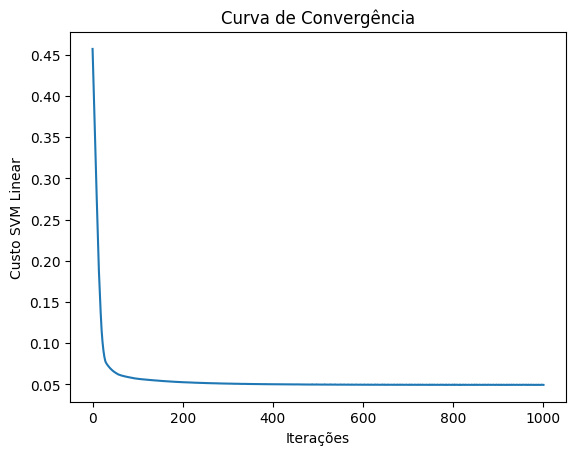

In [119]:
svm.curva_convergencia()